In [1]:
import numpy as np
import pandas as pd
import altair as alt

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from csi_extraction import read_log_file, read_csi, calc_frequency, calc_phase_angle

In [2]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

# 0. Data Transform (rename)
https://github.com/ermongroup/Wifi_Activity_Recognition/ Data

[[42.92798367 48.12815776 52.9899759  ... 18.87520229 12.03319194
   0.        ]
 [44.28006794 50.48608499 52.30635974 ... 20.16368196  8.2065087
   0.        ]
 [44.61940454 50.75278739 53.64012827 ... 30.83749356  6.90132387
   0.        ]
 ...
 [43.19949709 51.42811844 54.76827047 ... 21.79893651  7.48937217
   0.        ]
 [42.55514381 48.43107965 51.18469757 ... 11.60166579  9.82458884
   0.        ]
 [33.04135532 40.57105702 47.94690498 ... 21.34196969  3.12850715
   0.        ]]


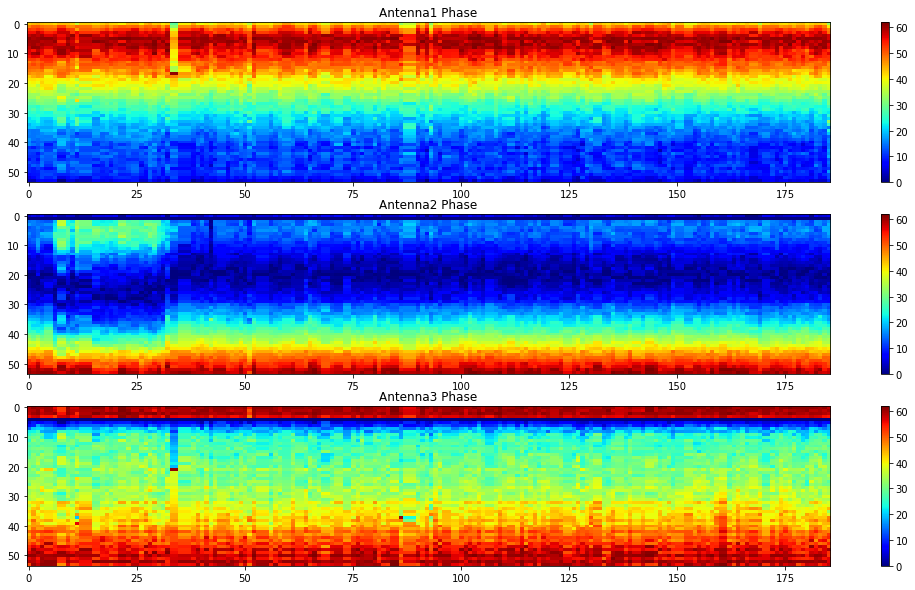

NameError: name 'calibrate_phase' is not defined

In [4]:
def convert_csv_file(path_to_data_csv_file, path_to_annotation_file=None):
    #data import
    data = pd.read_csv(path_to_data_csv_file, header=None).values

#     # plot Amplitude
#     amp = data[:,1:121]
        
#     fig = plt.figure(figsize = (18,10))
#     ax1 = plt.subplot(311)
#     plt.imshow(amp[:,0:29].T,interpolation = "nearest", aspect = "auto", cmap="jet")
#     ax1.set_title("Antenna1 Amplitude")
#     plt.colorbar()

#     ax2 = plt.subplot(312)
#     plt.imshow(amp[:,30:59].T,interpolation = "nearest", aspect = "auto", cmap="jet")
#     ax2.set_title("Antenna2 Amplitude")
#     plt.colorbar()

#     ax3 = plt.subplot(313)
#     plt.imshow(amp[:,60:89].T,interpolation = "nearest", aspect = "auto", cmap="jet")
#     ax3.set_title("Antenna3 Amplitude")
#     plt.colorbar()
#     plt.show()
    
    
    # plot Phase
    phase = data[:,224:448]
    
    print(phase)

    fig = plt.figure(figsize = (18,10))
    ax1 = plt.subplot(311)
    plt.imshow(phase[:,0:54].T,interpolation = "nearest", aspect = "auto", cmap="jet")
    ax1.set_title("Antenna1 Phase")
    plt.colorbar()

    ax2 = plt.subplot(312)
    plt.imshow(phase[:,54:108].T,interpolation = "nearest", aspect = "auto", cmap="jet")
    ax2.set_title("Antenna2 Phase")
    plt.colorbar()

    ax3 = plt.subplot(313)
    plt.imshow(phase[:,108:162].T,interpolation = "nearest", aspect = "auto", cmap="jet")
    ax3.set_title("Antenna3 Phase")
    plt.colorbar()
    plt.show()
    
    
    # plot Calibrated Phase
    phase = data[:,91:181]
    
#     phase1 = phase[:,0:29].T
    phase1 = phase[:,60:89].T
    calibrated_phase1 = np.zeros_like(phase1)

    for i in range(calibrated_phase1.shape[1]):
        calibrated_phase1[:, i] = calibrate_phase(phase1[:, i])
#         calibrated_phase1[:, i] = ((calibrated_phase1[:, i] - np.min(calibrated_phase1[:, i])) / (np.max(calibrated_phase1[:, i]) - np.min(calibrated_phase1[:, i])))
        
#     calibrated_phase1 = ((calibrated_phase1 - np.min(calibrated_phase1)) / (np.max(calibrated_phase1) - np.min(calibrated_phase1)))
    
    fig = plt.figure(figsize = (28,15))
    ax1 = plt.subplot(311)
    plt.imshow(calibrated_phase1, interpolation = "nearest", aspect = "auto", cmap="jet")
    ax1.set_title("Antenna1 Calibrated + Normalized Phase")
    plt.colorbar()

    plt.show()



convert_csv_file("./silence(no_ruhiv).csv", "./csv_data/annotation_run_170309_1314_14.csv")
# convert_csv_file("./csv_data/input_run_170309_1314_14.csv", "./csv_data/annotation_run_170309_1314_14.csv")

# 1. CSI data visualization notebook

In [9]:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/sys031fp.pdf
def calibrate_phase(phases): # Based on https://github.com/ermongroup/Wifi_Activity_Recognition/.../phase_calibration.m
    phases = np.array(phases)
    difference = 0

    calibrated_phase, calibrated_phase_final = np.zeros_like(phases), np.zeros_like(phases)   
    calibrated_phase[0] = phases[0]
    
    phases_len = phases.shape[0]
    
    for i in range(1, phases_len):
        temp = phases[i]- phases[i - 1]
        
        if abs(temp) > np.pi:
            difference = difference + 1*np.sign(temp)
            
        calibrated_phase[i] = phases[i] - difference * 2 * np.pi
        
    k = (calibrated_phase[-1] - calibrated_phase[0]) / (phases_len - 1)
    b = np.mean(calibrated_phase)
    
    for i in range(phases_len):
        calibrated_phase_final[i] = calibrated_phase[i] - k * i - b
        
    return calibrated_phase_final


def calibrate_amplitude(amplitudes, rssi): # Basic statistical normalization
    amplitudes = np.array(amplitudes)    
    return ((amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes))) * rssi

In [10]:
antenna_pairs_mapping = {  # data goes from 0 -> 1, 0 -> 0 etc. antenna
    0: (0, 0),
    1: (0, 1),
    2: (1, 0),
    3: (1, 1)
}


def process_csi_data(csi_structs):
    data = pd.DataFrame(columns=['antenna_pair_id', 'subcarry', 'freq', 'phase', 'time_moment', 'peak_amplidute', 'normalized_amplitude'])
    
    if len(csi_structs) == 0:
        return

    for packet_index, csi_struct in enumerate(csi_structs): # iterate over csi packets
        for antenna_pair_idx, (tr_i, rc_i) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]): # iterate over antenna pairs            
            # lists for storing packet data
            frequencies, subcarries, phases, peak_amplitudes, time_moments, antenna_pair_ids = [], [], [], [], [], []

            for i in range(0, csi_struct.num_tones): # iterate over packet data (over its carriers/freqs)
                p = csi_struct.csi[i][tr_i][rc_i]
                imag, real = p.imag, p.real
                
                peak_amplitude = np.sqrt(np.power(real, 2) + np.power(imag, 2)) # calculate amplitude
                angle = calc_phase_angle(csi_struct.csi[i][tr_i][rc_i]) # calculate phase angle
                freq = calc_frequency(csi_struct.channel, i, csi_struct.num_tones) # calculate frequency
                
                # Update packet data info
                frequencies.append(freq)
                subcarries.append(i)
                phases.append(angle)
                peak_amplitudes.append(peak_amplitude)
                time_moments.append(packet_index)
                antenna_pair_ids.append(antenna_pair_idx)
                
            normalized_amplitudes = calibrate_amplitude(peak_amplitudes, csi_struct.rssi)
            calibrated_phases = calibrate_phase(np.unwrap(phases))
            
            data = data.append(pd.DataFrame.from_dict({
                'antenna_pair_id': antenna_pair_ids,
                'subcarry': subcarries,
                'freq': frequencies,
                'phase': np.unwrap(phases),
                'time_moment': time_moments,
                'peak_amplidute': peak_amplitudes,
                
                'normalized_amplitude': normalized_amplitudes,
                'calibrated_phase': calibrated_phases,
                'normalized_calibrated_phase': ((calibrated_phases - np.min(calibrated_phases)) / (np.max(calibrated_phases) - np.min(calibrated_phases)))
            }), ignore_index=True)

    return data

In [ ]:
def process_file():
    dirpath = ""
    csi_data_filenames = [
        "./data/sample_bigEndian.dat"
    ]

    for f in csi_data_filenames:
        print("Processing ", f)
        
        structs = read_log_file(dirpath + f)
        print(len(structs), " Structs found")
        
        return process_csi_data(structs)
    
df = process_file()

In [ ]:
df.head()

# Altair visualizations

In [ ]:
time_slider = alt.binding_range(min=0, max=df["time_moment"].max(), step=1, name='time: ')
time_selection = alt.selection_single(name="time_selector", fields=['time_moment'], bind=time_slider, init={'time_moment': 0})

base_plot = alt.Chart(df).mark_line(strokeWidth=2.5, opacity=1).encode(
    color = alt.Color("antenna_pair_id:N", 
                      scale=alt.Scale(scheme='category10'), 
                      legend = alt.Legend(direction = "vertical", orient="right", title="Antenna pair index", offset=10)
                     )
).add_selection(time_selection).transform_filter(time_selection).properties(
    width = 750, 
    height = 325
)

## Phase visualization plot

### No normalization (only np.unwrap())

In [ ]:
phase_plot_no_normalization = base_plot.encode(
    x = alt.X('freq'),
    y = alt.Y('phase:Q', scale = alt.Scale(domain=[-4, 14]))
)

phase_plot_no_normalization

### CSI Phase with **calibration**

https://github.com/ermongroup/Wifi_Activity_Recognition/tree/master/datfile_convert_final

In [ ]:
phase_plot_calibration = base_plot.encode(
    x = alt.X('freq'),
    y = alt.Y('calibrated_phase:Q', scale = alt.Scale(domain=[-7, 2])),
)

phase_plot_calibration

### CSI phase with calibration and normalization

In [ ]:
phase_plot_calibration_normalization = base_plot.encode(
    x = alt.X('freq'),
    y = alt.Y('normalized_calibrated_phase:Q', scale = alt.Scale(domain=[-2, 2])),
)

phase_plot_calibration_normalization

## CSI Amplitude visualization plot

### No normalization

In [ ]:
amplitude_plot_no_normalization = base_plot.encode(
    x = alt.X('freq'),
    y = alt.Y('peak_amplidute:Q', scale = alt.Scale(domain=[0, 255])),
)

amplitude_plot_no_normalization

## With normalization  (basic statistical)

In [ ]:
amplitude_plot_normalization = base_plot.encode(
    x = alt.X('freq'),
    y = alt.Y('normalized_amplitude:Q', scale = alt.Scale(domain=[0, 70])),
)

amplitude_plot_normalization

## Putting two charts Phase + CSI together

### 1. Normalided amplitude and sanitized(calibrated)+normalized phase

In [ ]:
alt.vconcat(amplitude_plot_normalization, phase_plot_calibration_normalization)

# 2. "Through time" visualization

In [ ]:
time_df = df[['antenna_pair_id', 'subcarry', 'normalized_amplitude', 'normalized_calibrated_phase', 'time_moment']]

time_df.head()

In [ ]:
subcarry_slider = alt.binding_range(min=0, max=time_df["subcarry"].max(), step=1, name='subcarry: ')
subcarry_selection = alt.selection_single(name="subcarry", fields=['subcarry'], bind=subcarry_slider, init={'subcarry': 0})

base_time_plot = alt.Chart(time_df).mark_line(strokeWidth=2.5, opacity=1).encode(
    color = alt.Color("antenna_pair_id:N", scale=alt.Scale(scheme='category10'), 
                      legend = alt.Legend(direction = "vertical", orient="right", title="Antenna pair index", offset=10)),
).add_selection(subcarry_selection).transform_filter(subcarry_selection).properties(
    width = 750, 
    height = 325
)

## 2.1 Time-Amplitude plot

In [ ]:
time_amplitude_plot = base_time_plot.encode(
    x = alt.X('time_moment'),
    y = alt.Y('normalized_amplitude:Q', scale = alt.Scale(domain=[0, 70]))
)

time_amplitude_plot

## 2.2 Time-phase plot

In [ ]:
time_phase_plot = base_time_plot.encode(
    x = alt.X('time_moment'),
    y = alt.Y('normalized_calibrated_phase:Q', scale = alt.Scale(domain=[0, 1]))
)

time_phase_plot

## 2.3 Concat time amplitude+phase plots

In [ ]:
alt.vconcat(time_amplitude_plot, time_phase_plot)

# 3. "Medium" filtering data processing

In [6]:
# to do...

# 4. Photo shooting

In [8]:
import cv2

cam = cv2.VideoCapture(0)

# cv2.namedWindow("test")
img_counter = 1

ret, frame = cam.read()
# cv2.imshow("test", frame)
# if not ret:
#     break
# k = cv2.waitKey(1)

# if k%256 == 27:
#     # ESC pressed
#     print("Escape hit, closing...")
#     break
# elif k%256 == 32:
#     # SPACE pressed

img_name = "opencv_frame_{}.png".format(img_counter)
cv2.imwrite(img_name, frame)

print("{} written!".format(img_name))
img_counter += 1

cam.release()

cv2.destroyAllWindows()

opencv_frame_1.png written!
